# Demo
Integrating sub-cellular spots into single-cellular spots based on an improved version of TopACT (i.e., pytacs here).

In [1]:
import pytacs
import scanpy as sc
import seaborn as sns

In [2]:
# Step 1. Prepare the snRNA-seq and spRNA-seq data
data_preper = pytacs.AnnDataPreparer(
    sn_adata=sc.read_h5ad('snRNA_mouse_demo.h5ad'),
    sp_adata=sc.read_h5ad('spRNA_mouse_demo.h5ad'),
)
print(data_preper)

--- AnnDataPreparer (pytacs) ---
- sn_adata: AnnData object with n_obs × n_vars = 2000 × 769
    obs: 'cell_type', 'old_index'
- sp_adata: AnnData object with n_obs × n_vars = 6556 × 5227
    obs: 'x', 'y', 'old_index'
- sn_adata_withNegativeControl: _UNDEFINED
- normalized: False
--- --- --- --- ---



In [3]:
data_preper.simulate_negative_control(ratio_samplingFrom=0.2, negative_samples_proportion=0.2, ratio_mask=0.7)

/home/xndliu/xtdisk/xndliu/conda_envs/bio-py312/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 2500 × 769
    obs: 'cell_type'

In [4]:
data_preper.normalize()
data_preper

/home/xndliu/xtdisk/xndliu/conda_envs/bio-py312/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


--- AnnDataPreparer (pytacs) ---
- sn_adata: AnnData object with n_obs × n_vars = 2000 × 769
    obs: 'cell_type', 'old_index'
- sp_adata: AnnData object with n_obs × n_vars = 6556 × 5227
    obs: 'x', 'y', 'old_index'
- sn_adata_withNegativeControl: AnnData object with n_obs × n_vars = 2500 × 769
    obs: 'cell_type'
- normalized: True
--- --- --- --- ---

In [5]:
# Step 2. Train a local classifer
clf = pytacs.LocalClassifier(threshold_confidence=0.5)
clf.fit(
    sn_adata=data_preper.sn_adata_withNegativeControl
)

LocalClassifier(threshold_confidence=0.5)

In [6]:
# Step 3. Integrate spatial spots into single-cell spots
sph = pytacs.SpatialHandler(adata_spatial=data_preper.sp_adata,
                            local_classifier=clf,
                            max_spots_per_cell=8,
                            threshold_adjacent=1.2,
                            )
print(sph)

--- Spatial Handler (pytacs) ---
- adata_spatial: AnnData object with n_obs × n_vars = 6556 × 5227
    obs: 'x', 'y', 'old_index'
- threshold_adjacent: 1.2
- local_classifier: LocalClassifier(threshold_confidence=0.5)
    + threshold_confidence: 0.5
    + has_negative_control: True
- max_spots_per_cell: 8
- scale_rbf: 1.0
- filtrations: 0 fitted
- single-cell segmentation:
    + new samples: 0
    + AnnData: _UNDEFINED
--- --- --- --- --- ---



In [7]:
sph.run_segmentation(
    coverage_to_stop=0.5,
    max_iter=300,
    verbose=False,
    warnings=False,
    print_summary=True,
)

--- Summary ---
Queried 300 spots (with replacement), of which 73 made up confident single cells.
Classes total: {1: 50, 0: 23}
Coverage: 1.48%
--- --- --- --- ---



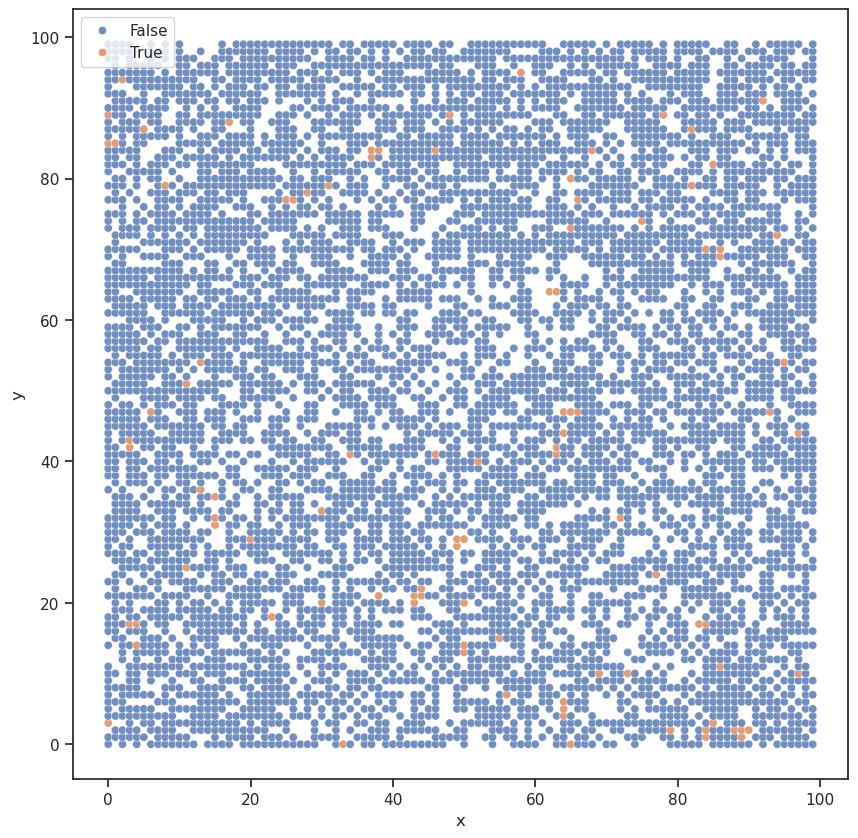

In [8]:
# See the integrated spots
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.set_theme(style='ticks')
sns.scatterplot(
    x=data_preper.sp_adata.obs['x'],
    y=data_preper.sp_adata.obs['y'],
    hue=sph.mask_newIds>-1,
    alpha=0.8,
)
plt.show()
# I used to use a 8-neighbor strategy so the shape might look quite dispersed;
# you can lower the threshold_adjacent to 1.2 or so to apply a 4-neighbor
# strategy for the shape to be denser.

In [9]:
# Get integrated single-cell level ST data
sp_singleCell = sph.run_getSingleCellAnnData()

In [10]:
print(sp_singleCell)

AnnData object with n_obs × n_vars = 73 × 5227
    obs: 'x', 'y', 'old_index', 'confidence'


In [11]:
sp_singleCell.obs['confidence']

2       0.950462
64      0.942064
135     0.786543
217     0.786543
233     0.617272
          ...   
6112    0.804806
6193    0.800888
6250    0.524043
6358    0.906334
6381    0.617272
Name: confidence, Length: 73, dtype: float64